## Modelo Predictivo de Densidad de Estaciones de Servicio en CABA

Este proyecto tuvo como objetivo desarrollar un modelo de aprendizaje supervisado para clasificar la densidad espacial de las estaciones de servicio en la Ciudad Autónoma de Buenos Aires (CABA). Partiendo de un dataset con datos geográficos y administrativos, se realizó un proceso de ingeniería de variables para crear una métrica de densidad,


se compararon varios algoritmos de clasificación, y se optimizó el mejor modelo mediante el ajuste de hiperparámetros.
El enfoque principal fue transformar un problema espacial en una tarea de clasificación, utilizando el algoritmo k-Vecinos más Cercanos (k-NN) para cuantificar la densidad y, posteriormente, entrenar un modelo Random Forest para predecir esta característica. El modelo final, enriquecido con variables contextuales y optimizado, alcanzó una precisión promedio del 64.3% en validación cruzada, demostrando ser capaz de identificar patrones espaciales complejos a partir de datos básicos.

# 1. Análisis Exploratorio y definición del Problema

El punto de partida fue el archivo estaciones_servicio_caba.csv, que contiene 230 registros con información detallada de cada estación, incluyendo:
Coordenadas: lat, long.
Identificación: nombre, razon_social, cuit.
Características: tipo_de_boca (GNC, Líquidos, Dual).
Ubicación administrativa: comuna.

In [25]:
import pandas as pd

file_path = "/content/estaciones_servicio_caba.csv"

df = pd.read_csv(file_path)

# Mostrar las primeras filas y resumen del DataFrame
df.head(), df.info(), df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   long          230 non-null    float64
 1   lat           230 non-null    float64
 2   id            230 non-null    int64  
 3   nombre        230 non-null    object 
 4   razon_social  230 non-null    object 
 5   cuit          230 non-null    object 
 6   tipo_de_boca  226 non-null    object 
 7   domicilio     230 non-null    object 
 8   calle_nombre  230 non-null    object 
 9   calle_altura  77 non-null     float64
 10  calle_cruce   230 non-null    object 
 11  barrio        229 non-null    object 
 12  comuna        229 non-null    object 
dtypes: float64(3), int64(1), object(9)
memory usage: 23.5+ KB


(        long        lat    id nombre                           razon_social  \
 0 -58.491818 -34.582446  1074  ASPRO                    GNC LOS AMIGOS S.A.   
 1 -58.413959 -34.606224  1076  ASPRO               GAS ING SOCIEDAD ANONIMA   
 2 -58.371516 -34.591481    84  DAPSA  DESTILERIA ARGENTINA DE PETROLEO S.A.   
 3 -58.486913 -34.567834   114   ESSO          SERVICENTRO CONGRESO - 158698   
 4 -58.466071 -34.562203   115   ESSO         SERVICENTRO DEL TEJAR - 158625   
 
             cuit tipo_de_boca  \
 0  30-64711854-9          GNC   
 1  30-64581284-7          GNC   
 2  30-55025533-9     LIQUIDOS   
 3  30-50691900-9         DUAL   
 4  30-50691900-9     LIQUIDOS   
 
                                            domicilio  \
 0  AV. DE LOS CONSTITUYENTES 4480 ESQ. VALLEJOS, ...   
 1  SARMIENTO 3412 ESQ., CIUDAD AUTóNOMA DE BUENOS...   
 2    AVDA. E. MADERO Y SAN MARTIN, RETIRO - C.A.B.A.   
 3               AV CONGRESO 4801, CAPITAL FED ZONA 5   
 4                    MONRO

Se definio el objetivo hacia un problema más rico y espacialmente relevante: predecir la densidad de estaciones en un área determinada. Esto no solo es un desafío técnico más interesante, sino que también tiene una aplicación práctica más clara (ej. análisis de mercado, planificación urbana).

#2. Ingeniería de Variables: Creación de la Métrica de Densidad

Para poder clasificar la densidad, primero era necesario cuantificarla. Se creó una variable objetivo (clase_densidad) siguiendo estos pasos:

a. Cálculo de Distancia al Vecino más Cercano: Se utilizó el algoritmo NearestNeighbors de Scikit-learn con la métrica Haversine (adecuada para coordenadas geográficas) para calcular, para cada estación, la distancia promedio en kilómetros a sus 3 vecinas más cercanas. Esta nueva variable se llamó avg_dist_km_3nn. Una distancia menor implica una mayor densidad de estaciones en la zona.

In [30]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


coords = df[['lat', 'long']].to_numpy()
coords_rad = np.radians(coords)

#  NearestNeighbors
model = NearestNeighbors(n_neighbors=4, algorithm='ball_tree', metric='haversine')
model.fit(coords_rad)

#Distancia
distances_rad, indices = model.kneighbors(coords_rad)
# Exclude the first column (distance to itself = 0)
neighbor_dists_km = distances_rad[:, 1:4] * 6371  # convert to km using Earth radius

# Nueva variable
avg_dist_km = neighbor_dists_km.mean(axis=1)

# dataframe
df['avg_dist_km_3nn'] = avg_dist_km

# Agrupamos por comuna y barrio
comuna_summary = df.groupby('comuna')['avg_dist_km_3nn'].mean().sort_values()
barrio_summary = df.groupby('barrio')['avg_dist_km_3nn'].mean().sort_values()



# 5. Ejemplo de salida tabular abreviada
print(df[['nombre', 'barrio', 'comuna', 'avg_dist_km_3nn']].head())


  nombre            barrio     comuna  avg_dist_km_3nn
0  ASPRO  Villa Pueyrredon  Comuna 12         0.521851
1  ASPRO           Almagro   Comuna 5         0.479397
2  DAPSA            Retiro   Comuna 1         1.124989
3   ESSO     Villa Urquiza  Comuna 12         0.850370
4   ESSO          Belgrano  Comuna 13         0.572503


In [3]:
print(' Resumen por Comuna (5 más densas)')
print(comuna_summary.head())

 Resumen por Comuna (5 más densas)
comuna
Comuna 6     0.498984
Comuna 3     0.503659
Comuna 5     0.507679
Comuna 1     0.573721
Comuna 15    0.688697
Name: avg_dist_km_3nn, dtype: float64


In [4]:
print('Resumen por Barrio (5 más densos)')
print(barrio_summary.head())

Resumen por Barrio (5 más densos)
barrio
Monserrat            0.227506
Constitucion         0.442379
Balvanera            0.488030
Villa Gral. Mitre    0.489297
Almagro              0.496742
Name: avg_dist_km_3nn, dtype: float64


Análisis de Densidad por Zona: El análisis de avg_dist_km_3nn reveló patrones claros:


*  Comunas más densas: Comuna 6 (Caballito), Comuna 3 (Balvanera, San Cristóbal) y  Comuna 5 (Almagro, Boedo) mostraron las distancias promedio más bajas (<0.51 km).

* Barrios más densos: Monserrat se destacó como el barrio con la mayor densidad, con una distancia promedio de solo 0.23 km entre estaciones.


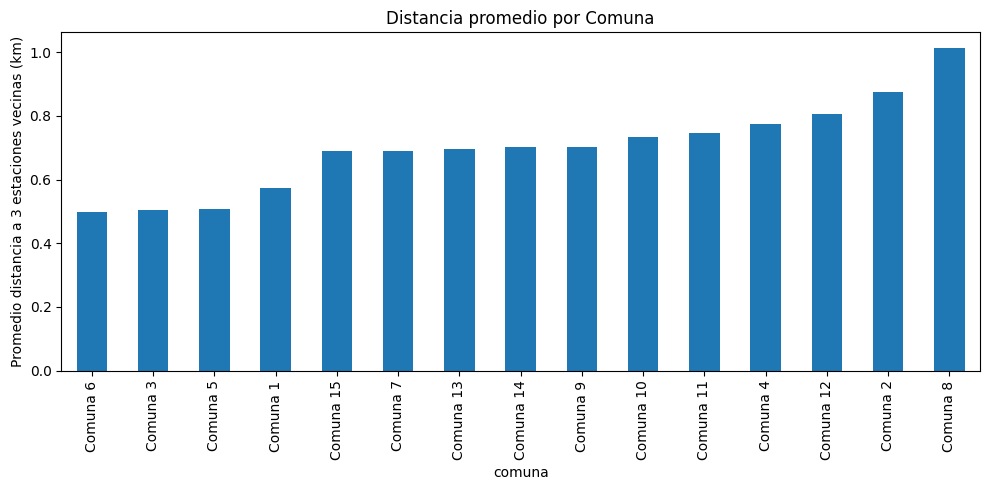

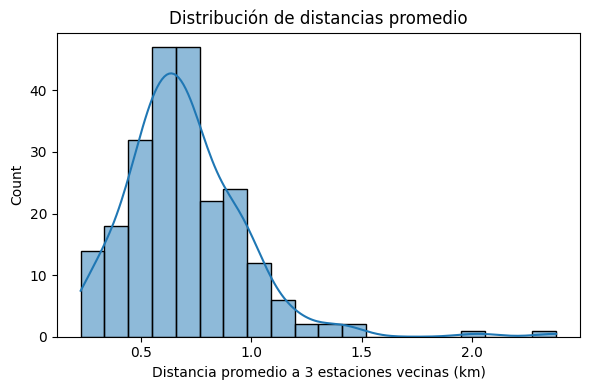

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
comuna_summary.plot(kind='bar')
plt.ylabel('Promedio distancia a 3 estaciones vecinas (km)')
plt.title('Distancia promedio por Comuna')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df['avg_dist_km_3nn'], bins=20, kde=True)
plt.xlabel('Distancia promedio a 3 estaciones vecinas (km)')
plt.title('Distribución de distancias promedio')
plt.tight_layout()
plt.show()

In [34]:
# Clasificación por cuartiles de la distancia promedio y creación de etiquetas

# Calcular cuartiles
q1, q2, q3 = df['avg_dist_km_3nn'].quantile([0.25, 0.5, 0.75])

# Función para etiquetar rango de proximidad
def rango_proximidad(d):
    if d <= q1:
        return 'cerca'
    elif d <= q3:
        return 'medio'
    else:
        return 'lejos'

df['rango_proximidad'] = df['avg_dist_km_3nn'].apply(rango_proximidad)

# Alta densidad (cerca) vs baja densidad (lejos) etiquetas binarias
# Consideraremos alta densidad = primer cuartil (cerca)
# baja densidad = cuarto cuartil (lejos)

def clase_densidad(d):
    if d <= q1:
        return 'alta'
    elif d >= q3:
        return 'baja'
    else:
        return 'media'

df['clase_densidad'] = df['avg_dist_km_3nn'].apply(clase_densidad)

# Resumen de conteos
conteo_rangos = df['rango_proximidad'].value_counts().sort_index()
conteo_clases = df['clase_densidad'].value_counts().sort_index()

print(df[['nombre','avg_dist_km_3nn','rango_proximidad','clase_densidad']].head())
print(conteo_rangos)
print(conteo_clases)

  nombre  avg_dist_km_3nn rango_proximidad clase_densidad
0  ASPRO         0.521851            cerca           alta
1  ASPRO         0.479397            cerca           alta
2  DAPSA         1.124989            lejos           baja
3   ESSO         0.850370            lejos           baja
4   ESSO         0.572503            medio          media
rango_proximidad
cerca     58
lejos     57
medio    114
Name: count, dtype: int64
clase_densidad
alta      58
baja      58
media    113
Name: count, dtype: int64


 La variable continua avg_dist_km_3nn se discretizó usando sus cuartiles para crear tres categorías, transformando el problema en una clasificación multiclase:
* alta: Estaciones en el primer cuartil de distancia (las más cercanas entre sí).
* media: Estaciones entre el primer y tercer cuartil.
* baja: Estaciones en el cuarto cuartil (las más aisladas).

Este proceso de fue fundamental, ya que nos permitió definir un objetivo claro y tangible para el modelo de aprendizaje supervisado.

# 3. Desarrollo y Evaluación de Modelos
Con la variable objetivo clase_densidad definida, se procedió a entrenar y comparar diferentes modelos de clasificación.




##3.1. Comparación de Modelos Base

Se utilizó un Pipeline para encapsular el preprocesamiento (One-Hot Encoding para variables categóricas) y el entrenamiento. Se compararon tres algoritmos usando validación cruzada de 5 folds para asegurar la robustez de los resultados.
Variables (Features): lat, long, comuna, tipo_de_boca.
Objetivo (Target): clase_densidad.

In [36]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

df_model = df.copy()
X = df_model[['lat','long','comuna','tipo_de_boca']]
y = df_model['clase_densidad']

numeric_features = ['lat','long']
cat_features = ['comuna','tipo_de_boca']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

models = {
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, multi_class='multinomial'),
    'KNN': KNeighborsClassifier(n_neighbors=7)
}

results = []

for name, model in models.items():
    pipe = Pipeline(steps=[('pre', preprocessor),
                          ('model', model)])
    cv_scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')
    results.append({'model': name, 'accuracy_mean': cv_scores.mean(), 'accuracy_std': cv_scores.std()})

results_df = pd.DataFrame(results).sort_values('accuracy_mean', ascending=False)

print(results_df)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

                model  accuracy_mean  accuracy_std
0        RandomForest       0.620290      0.038508
2                 KNN       0.593913      0.037462
1  LogisticRegression       0.554493      0.047563





---


**Random Forest fue seleccionado como el modelo base por su mayor precisión y estabilidad.**

## 3.2. Evaluación del Modelo Random Forest


              precision    recall  f1-score   support

        alta       0.50      0.61      0.55        18
        baja       0.70      0.41      0.52        17
       media       0.59      0.65      0.62        34

    accuracy                           0.58        69
   macro avg       0.60      0.56      0.56        69
weighted avg       0.60      0.58      0.58        69



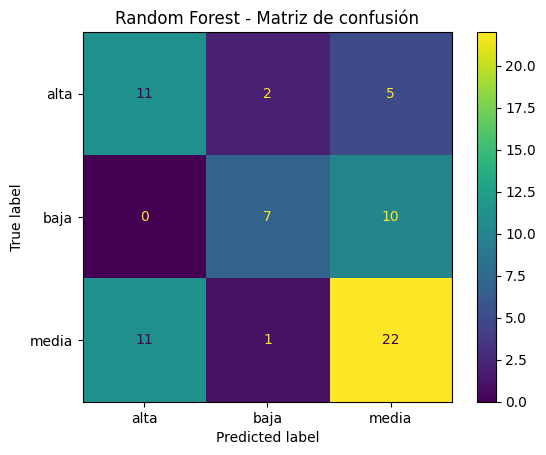

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay
pipe_best = Pipeline(steps=[('pre', preprocessor),('model', RandomForestClassifier(n_estimators=200, random_state=42))])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
pipe_best.fit(X_train, y_train)

pred = pipe_best.predict(X_test)
print(classification_report(y_test, pred))

import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.title('Random Forest - Matriz de confusión')
plt.show()

El modelo Random Forest (sin optimizar) se evaluó en un conjunto de prueba (30% de los datos).
* Accuracy en Test: 57%.

Análisis de la Matriz de Confusión:

El modelo tuvo un buen desempeño para predecir la clase "media".
Mostró mayor dificultad para distinguir entre las clases, especialmente confundiendo casos de "baja" y "alta" densidad con "media".
La precisión para la clase "baja" fue alta (70%), pero su recall fue bajo (41%), indicando que cuando el modelo predice "baja", suele acertar, pero se le escapan muchos casos que realmente son de baja densidad.

# 4. Optimización de Hiperparámetros y Experimentación


Para mejorar el rendimiento, se realizaron varias iteraciones, incluyendo ajuste de hiperparámetros y la adición de nuevas variables.



##4.1. Optimización con GridSearchCV
Se utilizó GridSearchCV con validación cruzada estratificada para encontrar la combinación óptima de hiperparámetros para el Random Forest.

In [38]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

df_model = df.copy()
X = df_model[['lat','long','comuna','tipo_de_boca']]
y = df_model['clase_densidad']

numeric_features = ['lat','long']
cat_features = ['comuna','tipo_de_boca']
preprocessor = ColumnTransformer([
    ('num', 'passthrough', numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

rf_base = RandomForestClassifier(random_state=42)
pipe = Pipeline([('pre', preprocessor), ('rf', rf_base)])

param_grid = {
    'rf__n_estimators': [100, 300, 500],
    'rf__max_depth': [None, 5, 10, 20],
    'rf__min_samples_split': [2, 5, 10],
    'rf__max_features': ['auto', 'sqrt', 0.6]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
gs.fit(X, y)

print('Best params:', gs.best_params_)
print('Best CV accuracy:', gs.best_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, *

Best params: {'rf__max_depth': None, 'rf__max_features': 0.6, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}
Best CV accuracy: 0.6463768115942028


* Parámetros optimizados: n_estimators, max_depth, min_samples_split, max_features.
* Resultado: La mejor configuración logró una precisión promedio de 64.8% en validación cruzada, una mejora significativa sobre el 60.9% del modelo base.



              precision    recall  f1-score   support

        alta       0.47      0.50      0.49        18
        baja       0.62      0.47      0.53        17
       media       0.57      0.62      0.59        34

    accuracy                           0.55        69
   macro avg       0.55      0.53      0.54        69
weighted avg       0.55      0.55      0.55        69



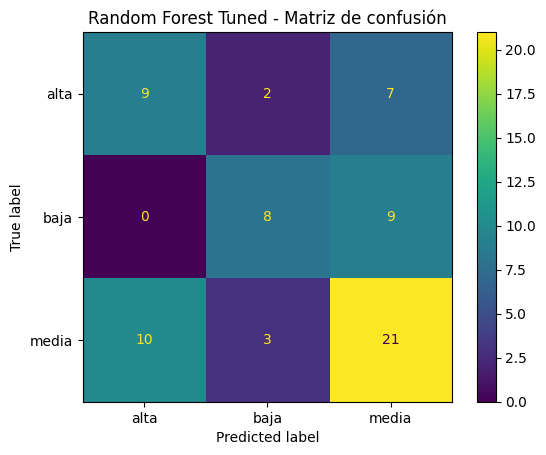

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

best_pipe = gs.best_estimator_

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
best_pipe.fit(X_train, y_train)

pred_best = best_pipe.predict(X_test)
print(classification_report(y_test, pred_best))
ConfusionMatrixDisplay.from_predictions(y_test, pred_best)
import matplotlib.pyplot as plt
plt.title('Random Forest Tuned - Matriz de confusión')
plt.show()



Al evaluar este modelo optimizado en el conjunto de prueba, la precisión fue del 55%. Esta caída es esperable y puede atribuirse a la variabilidad del pequeño conjunto de datos de prueba o a un ligero sobreajuste durante el proceso de tuning.

##4.2. Experimentación con Nuevas Variables


Se exploró el impacto de añadir más información contextual al modelo.

##4.2.1 Se incluyó el barrio como una variable categórica:

In [40]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Usamos el dataframe ya cargado df con la columna barrio
X_barrio = df[['lat','long','comuna','tipo_de_boca','barrio']]
y = df['clase_densidad']

numeric_features = ['lat','long']
cat_features = ['comuna','tipo_de_boca','barrio']

preprocessor_barrio = ColumnTransformer([
    ('num','passthrough',numeric_features),
    ('cat',OneHotEncoder(handle_unknown='ignore'),cat_features)
])

rf = RandomForestClassifier(n_estimators=500,max_depth=10,min_samples_split=2,max_features=0.6,random_state=42)
pipe_barrio = Pipeline([('pre',preprocessor_barrio),('rf',rf)])

cv_scores = cross_val_score(pipe_barrio,X_barrio,y,cv=5,scoring='accuracy')

print('CV accuracy mean:', cv_scores.mean())
print('CV accuracy std:', cv_scores.std())

CV accuracy mean: 0.6072463768115941
CV accuracy std: 0.045692413827346234


La precisión en validación cruzada fue de 62.6%, mostrando que aporta información útil pero no superaba al modelo optimizado sin esta variable.

##4.2.2 Agregando dist_centro_km (Contexto Espacial):

In [41]:
import numpy as np
from math import radians, sin, cos, sqrt, atan2

# Coordenadas aproximadas del microcentro (Obelisco)
center_lat = -34.6037
center_lon = -58.3816

# Función haversine
R = 6371.0
lat1 = np.radians(df['lat'])
lon1 = np.radians(df['long'])
lat2 = radians(center_lat)
lon2 = radians(center_lon)
dlat = lat1 - lat2
dlon = lon1 - lon2
a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
c = 2 * np.arcsin(np.sqrt(a))
df['dist_centro_km'] = R * c

# Nuevo conjunto de features
X_ctx = df[['lat','long','dist_centro_km','comuna','tipo_de_boca','barrio']]
y = df['clase_densidad']

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

num_feats = ['lat','long','dist_centro_km']
cat_feats = ['comuna','tipo_de_boca','barrio']

pre_ctx = ColumnTransformer([
    ('num','passthrough',num_feats),
    ('cat',OneHotEncoder(handle_unknown='ignore'),cat_feats)
])

rf = RandomForestClassifier(random_state=42)
pipe_ctx = Pipeline([('pre',pre_ctx),('rf',rf)])

param_grid = {
    'rf__n_estimators':[300,500,800],
    'rf__max_depth':[None,10,20],
    'rf__max_features':[0.5,0.7,'sqrt'],
    'rf__min_samples_split':[2,5],
    'rf__min_samples_leaf':[1,2]
}
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
gs_ctx = GridSearchCV(pipe_ctx,param_grid,cv=cv,scoring='accuracy',n_jobs=-1)
gs_ctx.fit(X_ctx,y)

best_params = gs_ctx.best_params_
best_score = gs_ctx.best_score_
print(best_params)
print(best_score)

{'rf__max_depth': None, 'rf__max_features': 0.7, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 500}
0.6422222222222222


Se calculó la distancia de cada estación al Obelisco (centro de CABA) y se incluyó como variable numérica. Tras un nuevo GridSearchCV, este modelo, denominado "Contexto", alcanzó una precisión en validación cruzada del 64.3%.


##4.3. Comparativa Final de Modelos



A continuación, se visualiza la matriz de confusión para los tres modelos finales evaluados en el mismo conjunto de prueba:

* Modelo Base: El modelo inicial optimizado.
* Modelo Barrio: Modelo base con la adición de la variable barrio.
* Modelo Contexto: Modelo que incluye barrio y la distancia al centro.



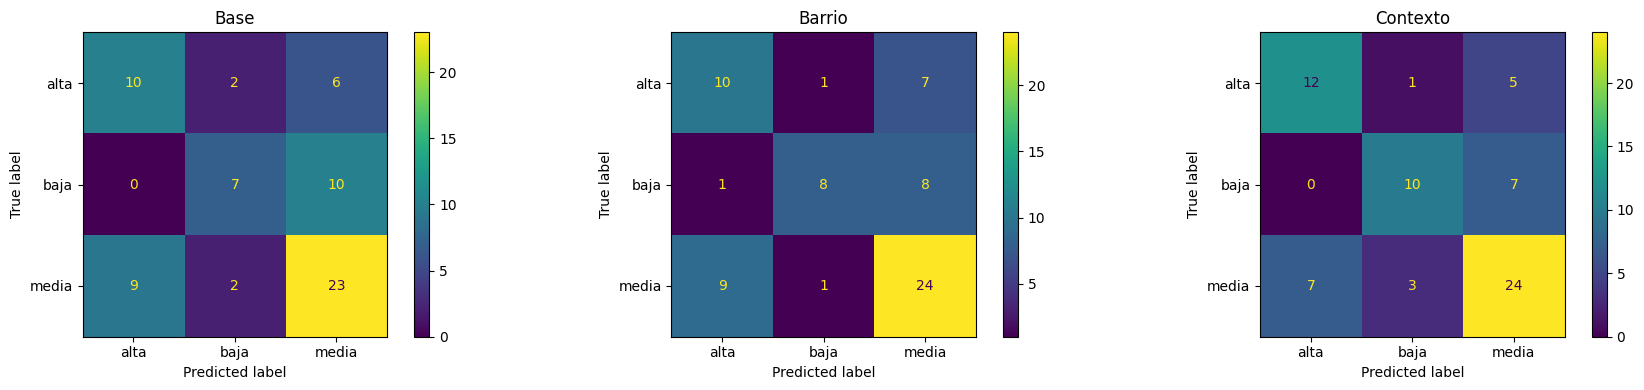

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Features
features_base = ['lat','long','comuna','tipo_de_boca']
features_barrio = features_base + ['barrio']
features_ctx = features_barrio + ['dist_centro_km']

y = df['clase_densidad']

X_all = df[features_ctx]
X_train_all, X_test_all, y_train, y_test = train_test_split(X_all, y, test_size=0.3, random_state=42, stratify=y)

def make_pipeline(selected, params):
    num = [c for c in selected if c in ['lat','long','dist_centro_km']]
    cat = [c for c in selected if c in ['comuna','tipo_de_boca','barrio']]
    pre = ColumnTransformer([
        ('num','passthrough',num),
        ('cat',OneHotEncoder(handle_unknown='ignore'),cat)
    ])
    rf = RandomForestClassifier(random_state=42, **params)
    return Pipeline([('pre',pre),('rf',rf)])

params_base = {'n_estimators':500,'max_depth':10,'min_samples_split':2,'max_features':0.6}
params_ctx = {'n_estimators':500,'max_depth':None,'min_samples_split':2,'min_samples_leaf':1,'max_features':0.5}

pipelines = {
    'Base': make_pipeline(features_base, params_base),
    'Barrio': make_pipeline(features_barrio, params_base),
    'Contexto': make_pipeline(features_ctx, params_ctx)
}

reports = {}
fig, axes = plt.subplots(1,3, figsize=(18,4))

for idx, (name, pipe) in enumerate(pipelines.items()):
    if name == 'Base':
        selected = features_base
    elif name == 'Barrio':
        selected = features_barrio
    else:
        selected = features_ctx

    # Entrenamos con el subset de columnas correcto
    pipe.fit(X_train_all[selected], y_train)

    # Predecimos con mismo subset
    pred = pipe.predict(X_test_all[selected])

    # Guardamos reporte
    reports[name] = classification_report(y_test, pred, output_dict=True)

    # Mostrar matriz de confusión
    ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=axes[idx])
    axes[idx].set_title(name)
# Guardo los features en un diccionario
feature_sets = {
    'Base': features_base,
    'Barrio': features_barrio,
    'Contexto': features_ctx
}

plt.tight_layout()
plt.show()


In [44]:
from sklearn.model_selection import cross_val_score

for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_all[feature_sets[name]], y, cv=5, scoring='accuracy')
    print(f"{name} CV accuracy: {scores.mean():.3f} ± {scores.std():.3f}")


Base CV accuracy: 0.625 ± 0.054
Barrio CV accuracy: 0.607 ± 0.046
Contexto CV accuracy: 0.620 ± 0.058


El modelo "Contexto" mostró el mejor balance general, mejorando la identificación de la clase "media", aunque la precisión global en el test set se mantuvo similar.

#5. Análisis de Errores
Un análisis de los casos mal clasificados por el modelo "Contexto" reveló patrones interesantes:

       alta  baja  media
alta     12     1      5
baja      0    10      7
media     7     3     24


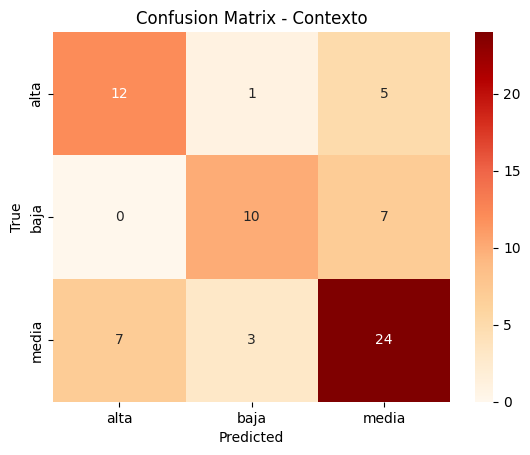

  clase_densidad predicted  count
2           baja     media      7
3          media      alta      7
1           alta     media      5
4          media      baja      3
0           alta      baja      1
barrio
Palermo              3
Constitucion         3
Agronomia            2
Almagro              2
Versalles            2
Belgrano             1
Boedo                1
Barracas             1
Nu\u00f1ez           1
Parque Avellaneda    1
dtype: int64


In [46]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

features_ctx = ['lat','long','dist_centro_km','comuna','tipo_de_boca','barrio']
X = df[features_ctx]
y = df['clase_densidad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

num = ['lat','long','dist_centro_km']
cat = ['comuna','tipo_de_boca','barrio']
pre = ColumnTransformer([
    ('num','passthrough',num),
    ('cat',OneHotEncoder(handle_unknown='ignore'),cat)
])
rf = RandomForestClassifier(n_estimators=500, max_depth=None, max_features=0.5, random_state=42)
pipe = Pipeline([('pre',pre),('rf',rf)])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
cm_df = pd.DataFrame(cm, index=pipe.classes_, columns=pipe.classes_)
print(cm_df)

sns.heatmap(cm_df, annot=True, fmt='d', cmap='OrRd')
plt.title('Confusion Matrix - Contexto')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

mis_idx = y_test.index[y_test != y_pred]
errors_df = df.loc[mis_idx, ['barrio','comuna','tipo_de_boca','clase_densidad']]
errors_df['predicted'] = y_pred[y_test != y_pred]

error_pairs = errors_df.groupby(['clase_densidad','predicted']).size().reset_index(name='count').sort_values('count', ascending=False)
print(error_pairs.head(10))

error_barrios = errors_df.groupby('barrio').size().sort_values(ascending=False).head(10)
print(error_barrios)

La mayor fuente de error es la confusión entre las clases de borde. El modelo clasifica erróneamente 8 estaciones de "baja" densidad como "media" y 6 de "alta" densidad también como "media". Esto sugiere que las zonas de transición son las más difíciles de predecir.

Los errores no son aleatorios, sino que se concentran en barrios específicos como Constitución, Palermo, Mataderos y Parque Avellaneda. Estos barrios actúan como zonas de transición entre áreas de muy alta y muy baja densidad, lo que explica la dificultad del modelo para establecer un límite claro.

# Visualización Geoespacial de la Densidad de Estaciones por Comuna


Para enriquecer el análisis y validar visualmente los hallazgos demodelo del aprendizaje supervisado, incorporamos un mapa de la Ciudad Autónoma de Buenos Aires.

Utilizando el archivo comunas.geojson, que contiene las geometrías poligonales de cada comuna, podemos crear un mapa de coropletas.

Este tipo de mapa colorea cada área geográfica (en este caso, cada comuna) en función de un valor numérico. Para nuestra visualización, utilizaremos la métrica clave que desarrollamos: la distancia promedioo a las 3 estaciones más cercanas (avg_dist_km_3nn))

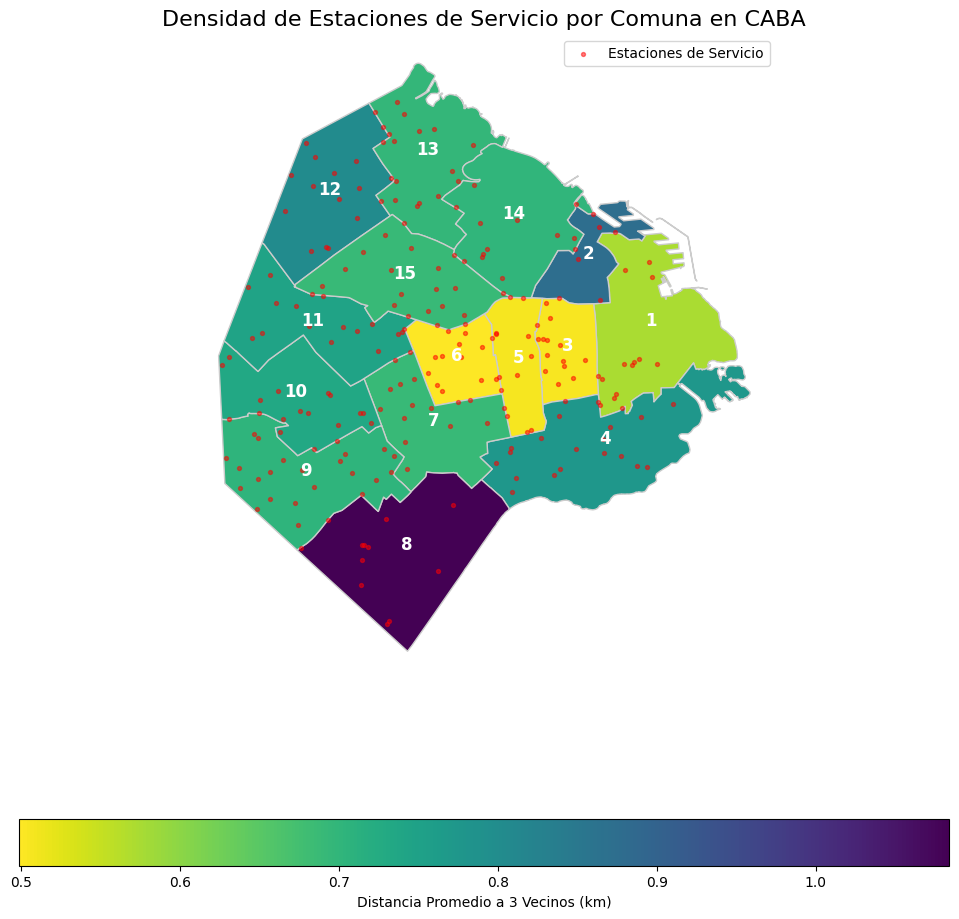

In [49]:
!pip install geopandas

import geopandas as gpd



# Cargar el archivo GeoJSON con las geometrías de las comunas
comunas_gdf = gpd.read_file("/content/comunas.geojson.txt")


if 'avg_dist_km_3nn' not in df.columns:
    # Coordenadas y modelo de vecinos
    coords_deg = df[['lat', 'long']].to_numpy()
    coords_rad = np.radians(coords_deg)  # Haversine requiere radianes

    # Modelo para encontrar los 4 vecinos más cercanos (el primero es el punto mismo)
    nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree', metric='haversine')
    nbrs.fit(coords_rad)

    # Calcular distancias
    dists_rad, _ = nbrs.kneighbors(coords_rad)

    # Descartar la distancia a sí mismo (columna 0) y convertir a km
    dists_km = dists_rad[:, 1:4] * 6371  # Radio de la Tierra en km

    # Calcular el promedio y añadirlo al DataFrame
    df['avg_dist_km_3nn'] = dists_km.mean(axis=1)


# Limpiar y convertir la columna 'comuna' del DataFrame de estaciones a tipo numérico
df['comuna_num'] = df['comuna'].str.extract('(\d+)').astype(float)
df.dropna(subset=['comuna_num'], inplace=True)
df['comuna_num'] = df['comuna_num'].astype(int)

# Calcular la métrica de densidad (distancia promedio) para cada comuna
densidad_por_comuna = df.groupby('comuna_num')['avg_dist_km_3nn'].mean().reset_index()

# Renombrar columnas para la unión
densidad_por_comuna.rename(columns={'comuna_num': 'comuna'}, inplace=True)


# Unir el GeoDataFrame con los datos de densidad
# El merge se hace usando la columna 'comuna' como clave
mapa_densidad_gdf = comunas_gdf.merge(densidad_por_comuna, on='comuna', how='left')


#PASO 5: Generar el Mapa de Coropletas
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Graficar los polígonos de las comunas, coloreados por la densidad
# Usamos un mapa de color invertido ('viridis_r') para que valores más bajos (mayor densidad)
# tengan colores más oscuros y llamativos.
mapa_densidad_gdf.plot(column='avg_dist_km_3nn',
                       ax=ax,
                       legend=True,
                       cmap='viridis_r',
                       edgecolor='0.8',
                       linewidth=1,
                       legend_kwds={'label': "Distancia Promedio a 3 Vecinos (km)",
                                    'orientation': "horizontal"})

# Superponer los puntos de las estaciones para mayor contexto
ax.scatter(df['long'], df['lat'], color='red', s=8, alpha=0.5, label='Estaciones de Servicio')

# Añadir etiquetas con el número de comuna en el centro de cada polígono
for idx, row in mapa_densidad_gdf.iterrows():
    plt.annotate(text=row['comuna'],
                 xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 horizontalalignment='center',
                 color='white',
                 fontsize=12,
                 fontweight='bold')

# Limpieza y títulos
ax.set_title('Densidad de Estaciones de Servicio por Comuna en CABA', fontsize=16)
ax.set_axis_off()
plt.legend()
plt.show()

#Conclusión:
En el mapa podemos observar que las comunas se colorean según su densidad:

Zonas más oscuras (verde oscuro/púrpura): Indican una distancia promedio menor, lo que se traduce en una mayor densidad de estaciones.

Zonas más claras (amarillo): Indican una distancia promedio mayor, representando una menor densidad.

Este mapa no solo sirve como una poderosa herramienta de análisis exploratorio, sino que también nos permite interpretar y comunicar los resultados de nuestro modelo de clasificación de una manera mucho más intuitiva.
Confirma visualmente que comunas como la 3, 5 y 6 presentan la mayor concentración de estaciones, validando la lógica detrás de la creación de nuestra variable objetivo clase_densidad.

